# Route Clustering Based on Delay Patterns
## Objective: Cluster flight routes (Origin-Destination pairs) by their monthly delay patterns

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Initialize Spark session
spark = SparkSession \
    .builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/02 16:28:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/02 16:28:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Read in data
flights_2018 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2018.parquet')
flights_2019 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2019.parquet')
flights_2020 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2020.parquet')
flights_2021 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2021.parquet')
flights_2022 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2022.parquet')

## Step 1: Data Transformation for Route Clustering
Transform data so that:
- Each row = one route (Origin-Destination pair)
- Each column = one year-month combination
- Cell value = proportion of delayed flights (ArrDel15 >= 1) for that route in that month

In [4]:
# Combine all years, select relevant columns, drop missing values
combined = flights_2018.union(flights_2019).union(flights_2020).union(flights_2021).union(flights_2022) \
    .select('FlightDate', 'Origin', 'Dest', 'ArrDel15').dropna()

# Create Route column (Origin-Dest pair)
combined = combined.withColumn('Route', F.concat_ws('-', F.col('Origin'), F.col('Dest')))

# Extract year and month from FlightDate
combined = combined.withColumn('Year', F.year('FlightDate')) \
                   .withColumn('Month', F.month('FlightDate')) \
                   .withColumn('YearMonth', F.concat_ws('-', F.col('Year'), F.lpad(F.col('Month'), 2, '0')))

# Group by route and YearMonth, calculate proportion of delayed flights
delay_prop = combined.groupBy('Route', 'YearMonth') \
                .agg(F.mean('ArrDel15').alias('delay_proportion'))

# Pivot so each route is a row and each YearMonth is a column
pivoted = delay_prop.groupBy('Route') \
            .pivot('YearMonth') \
            .agg(F.first('delay_proportion')) \
            .orderBy('Route')

# Fill NA values with 0 (assuming no delay data means no delays or no flights)
route_data = pivoted.fillna(0)

print(f'Shape of transformed route data: {route_data.count()} rows, {len(route_data.columns)} columns.')

[Stage 13:==================================================>     (10 + 1) / 11]

Shape of transformed route data: 8187 rows, 56 columns.


## Filter routes with sufficient data
Only keep routes that have flights in at least 12 months to ensure meaningful clustering

In [5]:
# Count non-zero months for each route
feats_all = route_data.columns[1:]  # Exclude 'Route' column

# Calculate number of active months per route
route_data_pd = route_data.toPandas()
route_data_pd['active_months'] = (route_data_pd[feats_all] > 0).sum(axis=1)

print(f'\nRoute activity statistics:')
print(route_data_pd['active_months'].describe())

# Filter routes with at least 12 active months
min_months = 12
route_data_filtered = route_data_pd[route_data_pd['active_months'] >= min_months].drop('active_months', axis=1)

print(f'\nOriginal routes: {len(route_data_pd)}')
print(f'Filtered routes (>= {min_months} months): {len(route_data_filtered)}')

# Convert back to Spark DataFrame
route_data = spark.createDataFrame(route_data_filtered)

25/12/02 16:35:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.



Route activity statistics:
count    8187.000000
mean       34.069378
std        19.180252
min         0.000000
25%        15.000000
50%        42.000000
75%        51.000000
max        55.000000
Name: active_months, dtype: float64

Original routes: 8187
Filtered routes (>= 12 months): 6531


## Step 2: Detect and Remove Outliers
First run k=2 to identify potential outliers

In [6]:
# Create feature vector
feats = route_data.columns[1:]  # Exclude 'Route' column
assembler = VectorAssembler(inputCols=feats, outputCol='features')
dataset = assembler.transform(route_data)

# Show dataset info
print(f'Total routes: {dataset.count()}')
print(f'Feature dimension: {len(feats)}')
dataset.select('Route', 'features').show(5)

25/12/02 16:38:00 WARN TaskSetManager: Stage 32 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.


Total routes: 6531
Feature dimension: 55
25/12/02 16:38:02 WARN TaskSetManager: Stage 35 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.
+-------+--------------------+
|  Route|            features|
+-------+--------------------+
|ABE-ATL|[0.21538461538461...|
|ABE-BNA|(55,[16,17,18,19,...|
|ABE-CLT|[0.0,0.0,0.0,0.0,...|
|ABE-DTW|[0.25,0.0,0.0,0.2...|
|ABE-FLL|[0.44444444444444...|
+-------+--------------------+
only showing top 5 rows



In [7]:
# Run KMeans with k=2 to detect outliers
kmeans_outlier = KMeans().setK(2).setSeed(314).setMaxIter(20)
model_outlier = kmeans_outlier.fit(dataset)
preds_outlier = model_outlier.transform(dataset)

# Check cluster distribution
cluster_counts = preds_outlier.groupBy('prediction').count().orderBy('count')
print('\nCluster distribution:')
cluster_counts.show()

# Identify minority cluster as potential outliers
minority_cluster = cluster_counts.first()['prediction']
minority_count = cluster_counts.first()['count']
total_count = dataset.count()
minority_ratio = minority_count / total_count

print(f'\nMinority cluster: Cluster {minority_cluster}')
print(f'Minority cluster size: {minority_count} ({minority_ratio*100:.2f}%)')

# Only remove outliers if minority cluster is < 5% of total
if minority_ratio < 0.05:
    outliers = preds_outlier.filter(F.col('prediction') == minority_cluster).select('Route')
    print(f'\nRoutes identified as outliers ({outliers.count()} routes):')
    outliers.show(50, truncate=False)
    remove_outliers = True
else:
    print(f'\nMinority cluster is too large ({minority_ratio*100:.2f}%), not treating as outliers.')
    outliers = spark.createDataFrame([], schema='Route string')
    remove_outliers = False

25/12/02 16:38:09 WARN TaskSetManager: Stage 36 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.


25/12/02 16:38:10 WARN TaskSetManager: Stage 37 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:38:10 WARN TaskSetManager: Stage 38 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:38:11 WARN TaskSetManager: Stage 39 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:38:11 WARN TaskSetManager: Stage 40 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:38:11 WARN TaskSetManager: Stage 41 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:38:11 WARN TaskSetManager: Stage 42 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:38:12 WARN TaskSetManager: Stage 44 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/


Cluster distribution:
25/12/02 16:38:17 WARN TaskSetManager: Stage 77 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.
+----------+-----+
|prediction|count|
+----------+-----+
|         0| 2895|
|         1| 3636|
+----------+-----+

25/12/02 16:38:17 WARN TaskSetManager: Stage 80 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:38:18 WARN TaskSetManager: Stage 83 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:38:19 WARN TaskSetManager: Stage 86 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.

Minority cluster: Cluster 0
Minority cluster size: 2895 (44.33%)

Minority cluster is too large (44.33%), not treating as outliers.


In [8]:
# Remove outliers from dataset if applicable
if remove_outliers:
    outlier_list = [row['Route'] for row in outliers.collect()]
    dataset_clean = dataset.filter(~F.col('Route').isin(outlier_list))
    
    print(f'Original dataset: {dataset.count()} routes')
    print(f'Cleaned dataset: {dataset_clean.count()} routes')
    print(f'Removed: {len(outlier_list)} routes')
else:
    dataset_clean = dataset
    print(f'No outliers removed. Using full dataset: {dataset_clean.count()} routes')

25/12/02 16:38:27 WARN TaskSetManager: Stage 89 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.
No outliers removed. Using full dataset: 6531 routes


## Step 3: Find Optimal k (from 2 to 10)
Use silhouette score to evaluate different k values

In [9]:
# Function to test different k values
def kmeans_range(lower, upper, data):
    """
    Test KMeans clustering with k from lower to upper
    Returns DataFrame with k and corresponding silhouette scores
    """
    output = pd.DataFrame(columns=['k', 'silhouette'])
    evaluator = ClusteringEvaluator()
    
    # Loop through k values
    for k in range(lower, upper+1, 1):
        print(f'Testing k={k}...')
        
        # Instantiate KMeans with current k
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(20)
        
        # Fit model
        model = kmeans.fit(data)
        
        # Predict clusters
        predictions = model.transform(data)
        
        # Evaluate with silhouette score
        silhouette = evaluator.evaluate(predictions)
        
        # Append results
        output = pd.concat([output, pd.DataFrame({'k': [k], 'silhouette': [silhouette]})], 
                          ignore_index=True)
        
        print(f'  Silhouette score: {silhouette:.4f}')
    
    return output

In [10]:
# Test k from 2 to 10
results = kmeans_range(2, 10, dataset_clean)
print('\nResults summary:')
print(results)

Testing k=2...
25/12/02 16:50:30 WARN TaskSetManager: Stage 92 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:50:31 WARN TaskSetManager: Stage 93 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:50:31 WARN TaskSetManager: Stage 94 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:50:31 WARN TaskSetManager: Stage 95 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:50:31 WARN TaskSetManager: Stage 96 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:50:31 WARN TaskSetManager: Stage 97 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:50:31 WARN TaskSetManager: Stage 98 contains a task of very large size (3245 KiB). The maximum recommended task size is 1

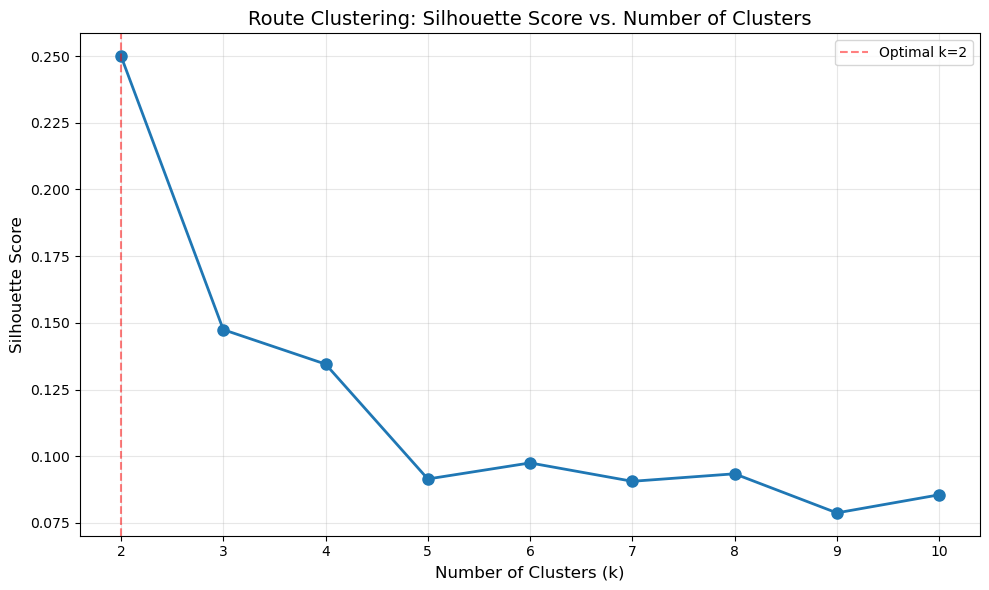


Optimal k: 2 with silhouette score: 0.2500


In [12]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(results['k'], results['silhouette'], marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Route Clustering: Silhouette Score vs. Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 11))

# Mark optimal k
optimal_k = results.loc[results['silhouette'].idxmax(), 'k']
optimal_score = results['silhouette'].max()
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.5, label=f'Optimal k={int(optimal_k)}')
plt.legend()
plt.tight_layout()
plt.show()

print(f'\nOptimal k: {int(optimal_k)} with silhouette score: {optimal_score:.4f}')

## Step 4: Final Clustering with Optimal k

In [13]:
# Use optimal k for final clustering
optimal_k_int = int(optimal_k)
kmeans_final = KMeans().setK(optimal_k_int).setSeed(314).setMaxIter(20)
model_final = kmeans_final.fit(dataset_clean)
predictions_final = model_final.transform(dataset_clean)

# Show cluster assignments (sample)
print(f'\nFinal clustering results (k={optimal_k_int}):')
predictions_final.select('Route', 'prediction').orderBy('prediction', 'Route').show(50, truncate=False)

25/12/02 16:54:04 WARN TaskSetManager: Stage 586 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:54:04 WARN TaskSetManager: Stage 587 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:54:04 WARN TaskSetManager: Stage 588 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:54:04 WARN TaskSetManager: Stage 589 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:54:04 WARN TaskSetManager: Stage 590 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:54:04 WARN TaskSetManager: Stage 591 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.
25/12/02 16:54:04 WARN TaskSetManager: Stage 592 contains a task of very large size (3245 KiB). The maximum recommended task size is 1000 KiB.

In [14]:
# Cluster size distribution
cluster_distribution = predictions_final.groupBy('prediction') \
    .agg(F.count('Route').alias('route_count')) \
    .orderBy('prediction')

print('\nCluster size distribution:')
cluster_distribution.show()

# Show sample routes from each cluster
print('\nSample routes from each cluster:')
for cluster_id in range(optimal_k_int):
    print(f'\n--- Cluster {cluster_id} ---')
    predictions_final.filter(F.col('prediction') == cluster_id) \
        .select('Route') \
        .limit(10) \
        .show(truncate=False)


Cluster size distribution:
25/12/02 16:54:09 WARN TaskSetManager: Stage 628 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.
+----------+-----------+
|prediction|route_count|
+----------+-----------+
|         0|       2895|
|         1|       3636|
+----------+-----------+


Sample routes from each cluster:

--- Cluster 0 ---
25/12/02 16:54:09 WARN TaskSetManager: Stage 631 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.
+-------+
|Route  |
+-------+
|ABE-FLL|
|ABE-ORD|
|ABE-PGD|
|ABE-PIE|
|ABE-SFB|
|ABQ-AUS|
|ABQ-DAL|
|ABQ-DEN|
|ABQ-IAH|
|ABQ-JFK|
+-------+


--- Cluster 1 ---
25/12/02 16:54:09 WARN TaskSetManager: Stage 632 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.
+-------+
|Route  |
+-------+
|ABE-ATL|
|ABE-BNA|
|ABE-CLT|
|ABE-DTW|
|ABE-IAD|
|ABE-MYR|
|ABE-PHL|
|ABE-SAV|
|ABE-SRQ|
|ABI-DFW|
+-------+



## Step 5: Analyze Cluster Characteristics
Calculate average delay proportion for each cluster to understand their patterns

25/12/02 16:54:16 WARN TaskSetManager: Stage 633 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.

Average delay proportion by cluster (sorted by delay rate):
Cluster 0: 0.1928 (2895 routes)
Cluster 1: 0.1049 (3636 routes)


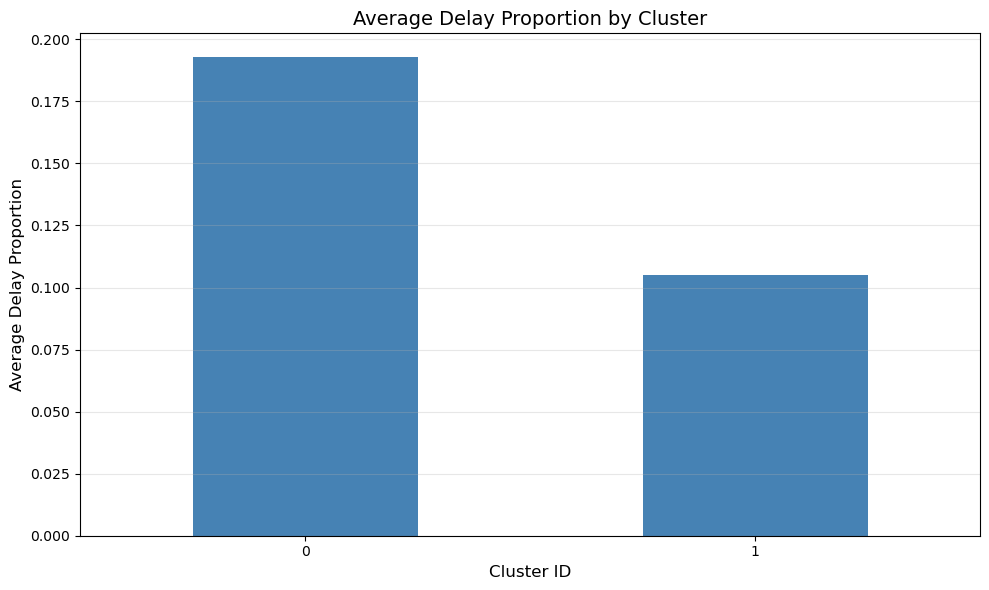

In [15]:
# Calculate mean delay proportion across all months for each cluster
predictions_pd = predictions_final.toPandas()

# Calculate average delay proportion per cluster
cluster_stats = predictions_pd.groupby('prediction')[feats].mean().mean(axis=1)
cluster_stats = cluster_stats.sort_values(ascending=False)

print('\nAverage delay proportion by cluster (sorted by delay rate):')
for cluster_id, avg_delay in cluster_stats.items():
    count = len(predictions_pd[predictions_pd['prediction'] == cluster_id])
    print(f'Cluster {cluster_id}: {avg_delay:.4f} ({count} routes)')

# Visualize cluster delay patterns
plt.figure(figsize=(10, 6))
cluster_stats.plot(kind='bar', color='steelblue')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Average Delay Proportion', fontsize=12)
plt.title('Average Delay Proportion by Cluster', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Step 6: Save Results

In [16]:
# Convert to pandas for easier analysis
route_clusters_pd = predictions_final.select('Route', 'prediction').toPandas()
route_clusters_pd.columns = ['Route', 'Cluster']
route_clusters_pd = route_clusters_pd.sort_values(['Cluster', 'Route'])

# Add origin and destination columns
route_clusters_pd[['Origin', 'Destination']] = route_clusters_pd['Route'].str.split('-', expand=True)

print(f'\nTotal routes clustered: {len(route_clusters_pd)}')
print(f'Number of clusters: {optimal_k_int}')
print('\nFirst 20 rows:')
print(route_clusters_pd.head(20))

# Save to CSV
route_clusters_pd.to_csv('route_clusters.csv', index=False)
print('\nResults saved to: route_clusters.csv')

25/12/02 16:54:24 WARN TaskSetManager: Stage 634 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.

Total routes clustered: 6531
Number of clusters: 2

First 20 rows:
      Route  Cluster Origin Destination
4   ABE-FLL        0    ABE         FLL
7   ABE-ORD        0    ABE         ORD
8   ABE-PGD        0    ABE         PGD
10  ABE-PIE        0    ABE         PIE
12  ABE-SFB        0    ABE         SFB
17  ABQ-AUS        0    ABQ         AUS
19  ABQ-DAL        0    ABQ         DAL
20  ABQ-DEN        0    ABQ         DEN
23  ABQ-IAH        0    ABQ         IAH
24  ABQ-JFK        0    ABQ         JFK
25  ABQ-LAS        0    ABQ         LAS
31  ABQ-ORD        0    ABQ         ORD
33  ABQ-PHX        0    ABQ         PHX
36  ABQ-SFO        0    ABQ         SFO
51  ACV-SFO        0    ACV         SFO
53  ACY-FLL        0    ACY         FLL
54  ACY-MCO        0    ACY         MCO
59  ADK-ANC        0    ADK         ANC
64  AEX-IAH        0    AEX  

In [17]:
# Save silhouette scores
results.to_csv('route_clustering_silhouette_scores.csv', index=False)
print('Silhouette scores saved to: route_clustering_silhouette_scores.csv')

Silhouette scores saved to: route_clustering_silhouette_scores.csv
